In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import dblquad
from scipy.integrate import quad
from tqdm.notebook import tqdm

import sys
sys.path.append("C:\\Users\\kenfl\\OneDrive\\Desktop\\Munch Research\\NS-Map\\NSMap")
import NSMapToolkit as ns
from modelSystems import *

import NSMapToolkit

%load_ext autoreload
%autoreload 2

In [2]:
# Define the likelihood function
def likelihood(data, theta, delta):
    (Xr, tx, E, tau) = data

    Xemb, Y, tx = ns.delayEmbed(Xr, E, tau, t=tx)

    # Replace this with the actual likelihood function
    # This is just a placeholder example
    return np.exp(ns.logLikelihood(Xemb, Y, tx, theta, delta))

# Define the exponentially decreasing prior function
def prior_1d(theta, lambda_t=1.0):
    return lambda_t * np.exp(-lambda_t * theta)

# Define the exponentially decreasing prior function
def prior_2d(theta, delta, lambda_d = 1.0, lambda_t=1.0):
    return lambda_t *lambda_d * np.exp(-lambda_t * theta) * np.exp(-lambda_d * delta)

def prior_E(E, p=0.5):
    return ((1 - p) ** E) * p

# Define the posterior function (likelihood * prior)
def posterior_1d(param1, data, lambda1=1.0):
    return likelihood(data, param1, 0) * prior_1d(param1, lambda1)

# Define the posterior function (likelihood * prior)
def posterior_2d(param1, param2, data, lambda1=1.0, lambda2=1.0):
    return likelihood(data, param1, param2) * prior_2d(param1, param2, lambda1, lambda2)

# Function to marginalize the posterior over the parameter space
def marginalize_likelihood_1d(data, param_range, lambda_=1.0):
    integral, error = quad(
        posterior_1d,
        param_range[0], param_range[1],  # Integration limits for the parameter
        args=(data, lambda_),
        epsrel=1e-5, epsabs=1e-5
    )
    return integral, error

# Function to marginalize the posterior over the parameter space
def marginalize_likelihood_2d(data, param1_range, param2_range, lambda1=1.0, lambda2=1.0):
    integral, error = dblquad(
        posterior_2d,
        param1_range[0], param1_range[1],  # Integration limits for param1
        lambda param1: param2_range[0], lambda param1: param2_range[1],  # Integration limits for param2
        args=(data, lambda1, lambda2),
        epsrel=1e-5, epsabs=1e-5
    )
    return integral, error

def marginalize_likelihood_E(marginal_likelihood_func, data, param_range, lambda_=1.0, p=0.5):
    marginal_likelihood = 0
    marginal_error = 0
    for E in range(param_range[0], param_range[1]):
        integral, error = marginal_likelihood_func(data, E, lambda_, p) * prior_E(E)
        marginal_likelihood += integral
        marginal_error += error
    return marginal_likelihood, marginal_error

def compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1=1.0, lambda2=1.0, p=0.5):

    marginal_likelihood_s = 0
    marginal_error_s = 0
    marginal_likelihood_ns = 0
    marginal_error_ns = 0

    for E in tqdm(range(E_range[0], E_range[1])):
        data_E = (data[0], data[1], E, data[2])

        # Marginalize the likelihood for SMap (null)
        integral_s, error_s = marginalize_likelihood_1d(data_E, theta_range, lambda1)
        marginal_likelihood_s += integral_s * prior_E(E)
        marginal_error_s += error_s

        # Marginalize the likelihood for NSMap
        integral_ns, error_ns = marginalize_likelihood_2d(data_E, theta_range, delta_range, lambda1, lambda2)
        marginal_likelihood_ns += integral_ns * prior_E(E)
        marginal_error_ns += error_ns

    # Compute the Bayes Factor
    bayes_factor = marginal_likelihood_ns / marginal_likelihood_s
    error_bf = marginal_error_s / marginal_likelihood_s + marginal_error_ns / marginal_likelihood_ns
    return bayes_factor, error_bf

In [3]:
# generate a sinusoidal time series with mean 0, standard deviation 1,
# and 10% observation noise
def generateLinearSeries(length=200, obs_noise=0.1, theta=lambda t: np.pi/6):
    init = rand.random(1) * 2 * np.pi
    
    t = np.linspace(0, 1, num = length)
    ts = np.sin(t * length * theta(t) + init) * np.sqrt(2)
    ts = ts + rand.normal(0, obs_noise, length)

    return ts

In [6]:
"""
L = 100

p_E = lambda E: tol**2 * np.exp(tol**2 * E / 8) / (8 * L)
x = np.linspace(1, L, 100)
plt.plot(x, p_E(x))
np.sum(p_E(x) * L/100)
"""

'\nL = 100\n\np_E = lambda E: tol**2 * np.exp(tol**2 * E / 8) / (8 * L)\nx = np.linspace(1, L, 100)\nplt.plot(x, p_E(x))\nnp.sum(p_E(x) * L/100)\n'

In [7]:
# General Hyperparameters
T = 200
o_n = 0.1
N_replicates = 1
reduction = 2 ** 8
settlingTime = 200
E_max = 5
tau = 1

In [8]:
# Linear Model NSMap vs DLM

λ=1
p = np.exp(-1/λ)
prior_E = lambda E : ((1 - p) ** (E - 1)) * p
prior_S = 0.5
prior_N = 1 - prior_S

theta_list = (lambda t: np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)

tol = 0.025

lambda1 = 1.0
lambda2 = 1.0
theta_range = [0, -np.log(tol / lambda1) / lambda1]
delta_range = [0, -np.log(tol / lambda2) / lambda2]

E_max = round(1 + np.log(tol / p) / np.log(1 - p))
E_range = [1, E_max]

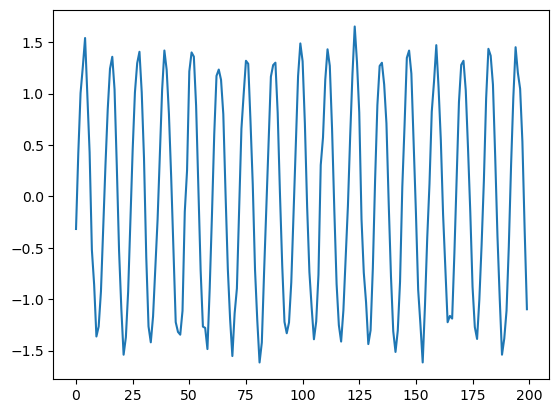

In [9]:
Xr = ns.standardize(generateLinearSeries(length=T, obs_noise=o_n, theta=theta_list[0]))
tx = np.linspace(0,1, num=len(Xr))
tau = 1

data = (Xr, tx, tau)

plt.plot(Xr)

In [10]:
# High Precision, takes 4.5 minutes.

SyntaxError: invalid syntax (265721023.py, line 1)

In [11]:
bayes_factor, bf_error = compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1, lambda2, p)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
print("Stationary Linear Series Bayes Factor: ", bayes_factor, "+/-", bf_error, "(evidence ", 10 * np.log10(bayes_factor), "dB)")

Stationary Linear Series Bayes Factor:  0.2833744501838309 +/- 0.0004892541466321917 (evidence  -5.4763930950277935 dB)


Low Precision, takes 2.5 minutes.

In [31]:
bayes_factor, bf_error = compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1, lambda2, p)

  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
print("Stationary Linear Series Bayes Factor: ", bayes_factor, "+/-", bf_error, "(evidence ", 10 * np.log10(bayes_factor), "dB)")

Stationary Linear Series Bayes Factor:  0.3024576406534463 +/- 3.5348804912664247 (evidence  -5.193354399160408 dB)


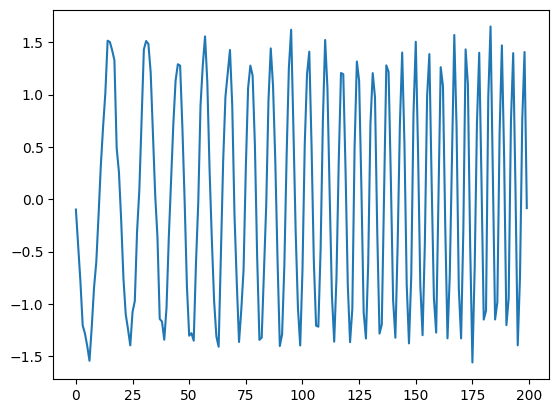

In [11]:
Xr = ns.standardize(generateLinearSeries(length=T, obs_noise=o_n, theta=theta_list[1]))
tx = np.linspace(0,1, num=len(Xr))
tau = 1

data = (Xr, tx, tau)

plt.plot(Xr)

In [12]:
bayes_factor, bf_error = compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1, lambda2, p)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
print("Nonstationary Linear Series Bayes Factor: ", bayes_factor, "+/-", bf_error, "(evidence ", 10 * np.log10(bayes_factor), "dB)")

Nonstationary Linear Series Bayes Factor:  5.901659781012654e+19 +/- 5.46857465823256 (evidence  197.7097416966959 dB)


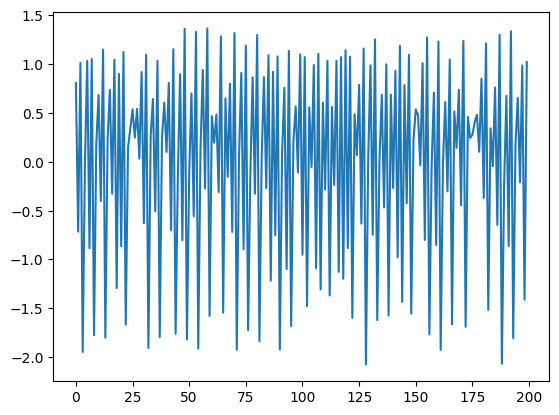

In [16]:
# Logistic Map NSMap vs DLM
r_list = (lambda t: 3.75, lambda t: 4.0 - t / T)

x0 = rand.rand(1)
Xr = ns.standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r_list[0],), settlingTime=settlingTime))
Xr += (rand.normal(0,1,T) * o_n)[:,None]
tx = np.linspace(0,1, num=len(Xr))
tau = 1

data = (Xr, tx, tau)

plt.plot(Xr)

In [17]:
bayes_factor, bf_error = compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1, lambda2, p)

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
print("Stationary Logistic Series Bayes Factor: ", bayes_factor, "+/-", bf_error, "(evidence ", 10 * np.log10(bayes_factor), "dB)")

Stationary Logistic Series Bayes Factor:  0.19816464286569893 +/- 0.06200696944013494 (evidence  -7.029738310723407 dB)


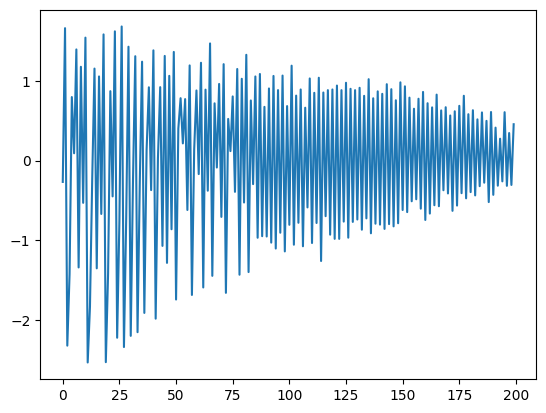

In [20]:
# Logistic Map NSMap vs DLM
x0 = rand.rand(1)
Xr = ns.standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r_list[1],), settlingTime=settlingTime))
Xr += (rand.normal(0,1,T) * o_n)[:,None]
tx = np.linspace(0,1, num=len(Xr))
tau = 1

data = (Xr, tx, tau)

plt.plot(Xr)

In [21]:
bayes_factor, bf_error = compute_bayes_factor(data, theta_range, delta_range, E_range, lambda1, lambda2, p)

  0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
print("Nonstationary Logistic Series Bayes Factor: ", bayes_factor, "+/-", bf_error, "(evidence ", 10 * np.log10(bayes_factor), "dB)")

Nonstationary Logistic Series Bayes Factor:  316703093.0622518 +/- 0.06737498231583812 (evidence  85.00652304904304 dB)


In [ ]:
"""
# Given a dataset, compute the probability that it is nonstationary
def nonstationary_probability(Xr, t, tau=1):

    p_x = 0
    p_x_s = 0
    
    # todo later: determine an Emax empirically beyond which the odds ratio won't update substantially
    for E in range(10):
        X, Y, tx = ns.delayEmbed(Xr, E, tau, t=t)

        _, _, lnLNS = ns.optimizeG(X, Y, tx, fixed=np.array([False, False]))
        # find optimal theta for NSMap using the same algorithm, holding theta fixed
        _, _, lnLS = ns.optimizeG(X, Y, tx, fixed=np.array([False, True]))

        p_x += np.exp(lnLNS) * prior_E(E)
        p_x_s += np.exp(lnLS) * prior_E(E)

        print(f"Prob of data = {p_x}")
        print(f"Prob of data conditional on S = {p_x_s}")

    odds = (p_x - p_x_s * prior_S) / (p_x_s * prior_S)
    
    return 1 / (1 + odds)
"""

In [ ]:
# some testing
assert sum([prior_E(E) for E in range(1, 200)]) - 1 < 1e-10